# Manual gene knockout

In [44]:
%%capture
%run gene_annotation.ipynb

from colorama import init, Fore, Style
from cobra import Model, Reaction
from cobra.io import read_sbml_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

model = read_sbml_model('Files/iCGB21FR.xml')

lys_exp_rxn = Reaction("LYSt3r")
lys_exp_rxn.name = "L lysine transport out via proton antiport reversible"
lys_exp_rxn.add_metabolites({model.metabolites.h_e: -1, model.metabolites.lys__L_c: -1, model.metabolites.h_c: 1, model.metabolites.lys__L_e: 1})
lys_exp_rxn.gene_reaction_rule = "( Mbar_A2583 or Mbar_A3244 )"
lys_exp_rxn.lower_bound, lys_exp_rxn.upper_bound = 0, 1000

model.add_reactions([lys_exp_rxn])

### Optimizing for MAX growth

In [47]:
model.objective = model.reactions.Growth
solution = model.optimize()
initial_growth, initial_lysine = solution['Growth'], solution['DAPDC']
print(f"Initial growth: {round(initial_growth, 6)}")
print(f"Initial lysine: {round(initial_lysine, 6)}")

Initial growth: 0.57066
Initial lysine: 0.189644


### Optimzing for MAX lysine production

In [48]:
model.objective = model.reactions.DAPDC
solution = model.optimize()
initial_growth, initial_lysine = solution['Growth'], solution['DAPDC']
print(f"Initial growth: {round(initial_growth, 6)}")
print(f"Initial lysine: {round(initial_lysine, 6)}")

Initial growth: 0.0
Initial lysine: 9.433333


### Optimizing for 80% of the MAX growth

In [7]:
model.reactions.Growth.bounds = (initial_growth*0.8, 1000)
model.objective = model.reactions.DAPDC
solution_2 = model.optimize()

print(f"New growth: {round(solution_2['Growth'], 6)}")
print(f"New lysine: {round(solution_2['DAPDC'], 6)}")

New growth: 0.456528
New lysine: 2.915677


### Explorinhg the full tradeoff space between growth and lysine production 

In [33]:
%%time
factor_scan = []

for factor in np.arange(0.0, 1.0, 0.0001):
    model.reactions.Growth.bounds = (initial_growth*factor, 1000)
    model.objective = model.reactions.DAPDC
    solution = model.optimize()

    factor_scan.append({
        "Growth": solution['Growth'],
        "lysine": solution['DAPDC'],
        "factor": factor
    })

df = pd.DataFrame(factor_scan, columns=["Growth", "lysine", "factor"])
df

Wall time: 2min 21s


,Growth,lysine,factor
0,0.000000,9.433333,0.0000
1,0.000057,9.432719,0.0001
2,0.000114,9.432105,0.0002
3,0.000171,9.431491,0.0003
4,0.000228,9.430878,0.0004
...,...,...,...
9995,0.570375,0.197592,0.9995
9996,0.570432,0.196003,0.9996
9997,0.570489,0.194413,0.9997
9998,0.570546,0.192823,0.9998


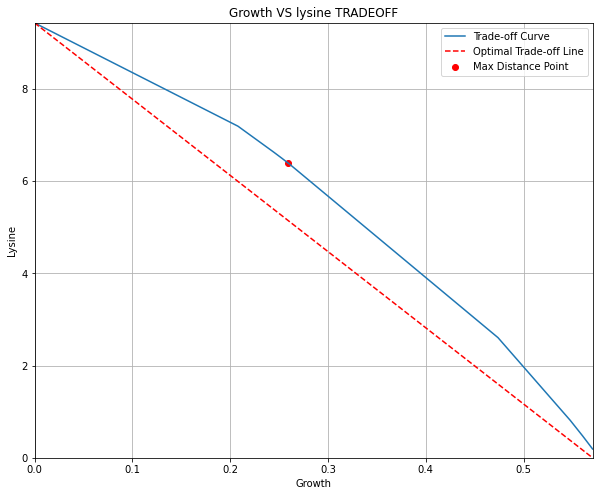

In [51]:
trade_off_curve = np.array([df['Growth'], df['lysine']]).T

line_start = np.array([0, max(df['lysine'])])
line_end = np.array([max(df['Growth']), 0])
line_vector = line_end - line_start
distances = np.abs(np.cross(line_vector, trade_off_curve - line_start)) / np.linalg.norm(line_vector)

max_distance_index = np.argmax(distances)
max_distance_point = trade_off_curve[max_distance_index]

plt.figure(figsize=(10, 8))

plt.plot(df['Growth'], df['lysine'], label='Trade-off Curve')
plt.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], 'r--', label='Optimal Trade-off Line')
plt.scatter(max_distance_point[0], max_distance_point[1], color='red', label='Max Distance Point')

plt.title('Growth VS lysine TRADEOFF')
plt.xlabel('Growth')
plt.ylabel('Lysine')
plt.xlim(0, max(df['Growth']))
plt.ylim(0, max(df['lysine']))
plt.legend()
plt.grid(True)
plt.show()

### Optimal values

In [83]:
#print(f"Point with Maximum Distance (optimum): {max_distance_point}")
optimal_growth, optimal_lysine = max_distance_point
optimal_factor = df.loc[max_distance_index, 'factor']

print(f"Optimal growth: {round(optimal_growth, 9)}", Fore.BLACK)
print(f"Optimal lysine: {round(optimal_lysine, 9)}", Fore.BLACK)
print(f"Optimal factor from MAX growth: {round(optimal_factor, 9)}", Fore.BLACK)

Optimal growth: 0.259193805 
Optimal lysine: 6.397160582 
Optimal factor from MAX growth: 0.4542 


In [79]:
0.57066*0.4542 

0.259193772

### The below calculations will use the optimal growth of 0.259194

In [87]:
%%capture

model = read_sbml_model('Files/iCGB21FR.xml')

In [88]:
lys_exp_rxn = Reaction("LYSt3r")
lys_exp_rxn.name = "L lysine transport out via proton antiport reversible"
lys_exp_rxn.add_metabolites({model.metabolites.h_e: -1, model.metabolites.lys__L_c: -1, model.metabolites.h_c: 1, model.metabolites.lys__L_e: 1})
lys_exp_rxn.gene_reaction_rule = "( Mbar_A2583 or Mbar_A3244 )"
lys_exp_rxn.lower_bound, lys_exp_rxn.upper_bound = 0, 1000
model.add_reactions([lys_exp_rxn])

model.reactions.Growth.bounds = (0.259193805 , 1000)
model.objective = model.reactions.DAPDC
solution = model.optimize()


print(f"New growth: {round(solution['Growth'], 6)}")
print(f"New lysine: {round(solution['DAPDC'], 6)}")

New growth: 0.259194
New lysine: 6.397161


In [93]:
single_KO_results = []

for gene in model.genes:
    with model:
        gene.knock_out()        
        protein_id = getProteinID(gene.id)
        
        solution = model.optimize()
        single_KO_results.append({
            "protein_id": protein_id,
            "growth": solution['Growth'],
            "lysine": solution['DAPDC']
        })

df_single_KO = pd.DataFrame(single_KO_results, columns=["protein_id", "growth", "lysine"])
df_single_KO

,protein_id,growth,lysine
0,WP_011015468,0.259194,6.397161
1,WP_003855288,0.259194,6.397161
2,WP_011013917,0.259194,6.397161
3,WP_003859251,0.259194,5.880308
4,WP_011015386,0.259194,6.397161
...,...,...,...
802,WP_011013607,0.259194,6.337323
803,WP_011013606,0.259194,6.337323
804,WP_011014733,0.259194,6.397161
805,None,0.259194,6.397161


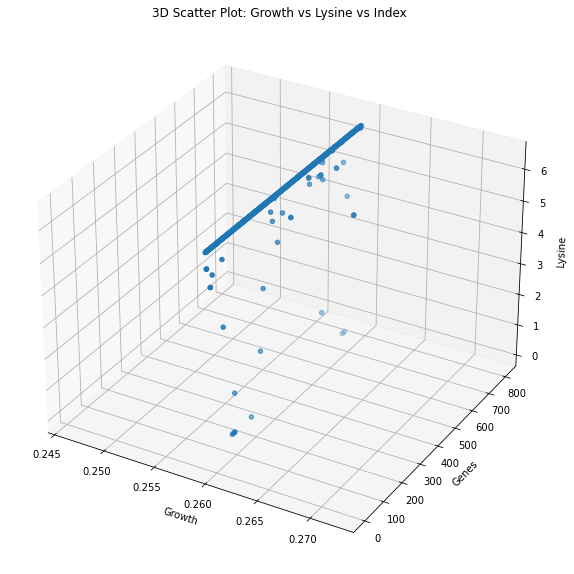

In [102]:
df_single_KO = df_single_KO.sort_values('growth')

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_single_KO['growth'], df_single_KO.index, df_single_KO['lysine'])

ax.set_xlabel('Growth')
ax.set_ylabel('Genes')
ax.set_zlabel('Lysine')

plt.title('3D Scatter Plot: Growth vs Lysine vs Index')
plt.show()

In [ ]:
from itertools import combinations

double_KO_results = []

for gene1, gene2 in combinations(model.genes, 2):
    with model:
        gene1.knock_out()
        gene2.knock_out()

        protein_id_1 = getProteinID(gene1.id)
        protein_id_2 = getProteinID(gene2.id)

        solution = model.optimize()

        double_KO_results.append({
            "protein_id_1": protein_id_1,
            "protein_id_2": protein_id_2,
            "growth": solution['Growth'],
            "lysine": solution['DAPDC']
        })

df_double_KO = pd.DataFrame(double_KO_results, columns=["protein_id_gene1", "protein_id_gene2", "growth", "lysine"])
df_double_KO

C:\Users\harou\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
